# Hybrid Movie Recommendation System Using Deep Learning and Transfer Learning Approaches

# 1. Import Required Libraries

In [44]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# 2. Load and Preprocess the Datasets

## Load the Datasets

In [45]:
# Load datasets
movies_dataset = pd.read_csv("tmdb_5000_movies.csv")
credits_dataset = pd.read_csv("tmdb_5000_credits.csv")

In [46]:
# Display first few rows
print(movies_dataset.head())

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

In [47]:
# Display first few rows
print(credits_dataset.head())

   movie_id                                     title  \
0     19995                                    Avatar   
1       285  Pirates of the Caribbean: At World's End   
2    206647                                   Spectre   
3     49026                     The Dark Knight Rises   
4     49529                               John Carter   

                                                cast  \
0  [{"cast_id": 242, "character": "Jake Sully", "...   
1  [{"cast_id": 4, "character": "Captain Jack Spa...   
2  [{"cast_id": 1, "character": "James Bond", "cr...   
3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
4  [{"cast_id": 5, "character": "John Carter", "c...   

                                                crew  
0  [{"credit_id": "52fe48009251416c750aca23", "de...  
1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
4  [{"credit_id": "52fe479ac3a36847f813eaa3",

## Handle Missing Values

In [48]:
# Fill missing values for 'homepage' and 'tagline'
movies_dataset['homepage'].fillna("Unknown", inplace=True)
movies_dataset['tagline'].fillna("Unknown", inplace=True)

/tmp/ipykernel_61647/1991616572.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  movies_dataset['homepage'].fillna("Unknown", inplace=True)
/tmp/ipykernel_61647/1991616572.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

## Merge Datasets

In [49]:
# Merge datasets on the 'title' column
merged_dataset = pd.merge(movies_dataset, credits_dataset, on='title', how='inner')

In [50]:
# Display merged dataset
print(merged_dataset.head())

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

## Map movie_id to a Contiguous Range

In [51]:
# Create a mapping for movie_id
unique_movie_ids = merged_dataset['movie_id'].unique()
movie_id_mapping = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}

In [52]:
# Apply the mapping
merged_dataset['mapped_movie_id'] = merged_dataset['movie_id'].map(movie_id_mapping)

In [53]:
# Verify mapping
print(merged_dataset[['movie_id', 'mapped_movie_id']].head())

   movie_id  mapped_movie_id
0     19995                0
1       285                1
2    206647                2
3     49026                3
4     49529                4


## Extract Relevant Features

In [54]:
# Extract features and target
features = merged_dataset[['mapped_movie_id', 'title', 'vote_average']]
target = merged_dataset['vote_average']  # Assuming we're predicting ratings

In [55]:
# Split into train and test sets
train, test = train_test_split(features, test_size=0.2, random_state=42)

In [56]:
# Separate inputs and target
train_movie_ids = train['mapped_movie_id'].values
train_titles = train['title'].values
train_ratings = train['vote_average'].values

test_movie_ids = test['mapped_movie_id'].values
test_titles = test['title'].values
test_ratings = test['vote_average'].values

# 3. Define the Deep Learning Model

## Create the Model

In [57]:
# Movie ID input
movie_input = Input(shape=(1,), name="Movie_Input")
movie_embedding = Embedding(input_dim=len(unique_movie_ids), output_dim=50, name="Movie_Embedding")(movie_input)
movie_flatten = Flatten()(movie_embedding)

# Title input
title_input = Input(shape=(1,), name="Title_Input")
title_embedding = Embedding(input_dim=5000, output_dim=50, name="Title_Embedding")(title_input)
title_flatten = Flatten()(title_embedding)

In [58]:
# Concatenate features
concatenated = Concatenate()([movie_flatten, title_flatten])
dense1 = Dense(128, activation='relu')(concatenated)
dropout1 = Dropout(0.3)(dense1)
dense2 = Dense(64, activation='relu')(dropout1)
output = Dense(1, activation='linear', name="Output")(dense2)


In [59]:
# Build the model
deep_learning_model = Model(inputs=[movie_input, title_input], outputs=output)
deep_learning_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
deep_learning_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Movie_Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Title_Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Movie_Embedding     │ (None, 1, 50)     │    240,150 │ Movie_Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Title_Embedding     │ (None, 1, 50)     │    250,000 │ Title_Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 50)        │          0 │ Movie_Embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 50)        │          0 │ Title_Embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 100)       │          0 │ flatten_5[0][0],  │
│ (Concatenate)       │                   │            │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     12,928 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      8,256 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 511,399 (1.95 MB)

 Trainable params: 511,399 (1.95 MB)

 Non-trainable params: 0 (0.00 B)

# 4. Train the Model

In [60]:
# Convert titles to tokenized integers (dummy example, use a tokenizer for real implementation)
train_titles_encoded = np.array([len(title) for title in train_titles])
test_titles_encoded = np.array([len(title) for title in test_titles])

In [61]:
# Train the model
history = deep_learning_model.fit(
    [train_movie_ids, train_titles_encoded], train_ratings,
    validation_data=([test_movie_ids, test_titles_encoded], test_ratings),
    epochs=10,
    batch_size=64
)

Epoch 1/10


/home/saky/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Movie_Input', 'Title_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 30.8786 - mae: 5.2905 - val_loss: 1.8690 - val_mae: 0.9855
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9246 - mae: 1.0308 - val_loss: 1.5080 - val_mae: 0.8726
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4196 - mae: 0.8411 - val_loss: 1.5118 - val_mae: 0.8943
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7690 - mae: 0.6131 - val_loss: 1.6799 - val_mae: 0.9755
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5701 - mae: 0.5674 - val_loss: 1.6178 - val_mae: 0.9470
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4746 - mae: 0.5161 - val_loss: 1.7361 - val_mae: 1.0053
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4086 - mae: 0.4868 - val_loss: 1.6829 - val_mae: 0.9779
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3659 - mae: 0.4681 - val_loss: 1.6592 - val_mae: 0.9702
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3501 - mae: 0.4638 - v

# 5. Evaluate the Model


In [62]:
# Evaluate the model
results = deep_learning_model.evaluate([test_movie_ids, test_titles_encoded], test_ratings)
print(f"Test Loss: {results[0]}")
print(f"Test MAE: {results[1]}")

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7406 - mae: 1.0133
Test Loss: 1.7113311290740967
Test MAE: 0.993534505367279


In [63]:
import matplotlib.pyplot as plt

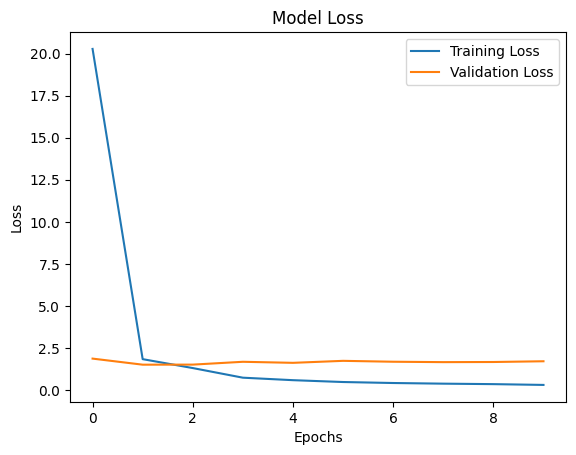

In [64]:
# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

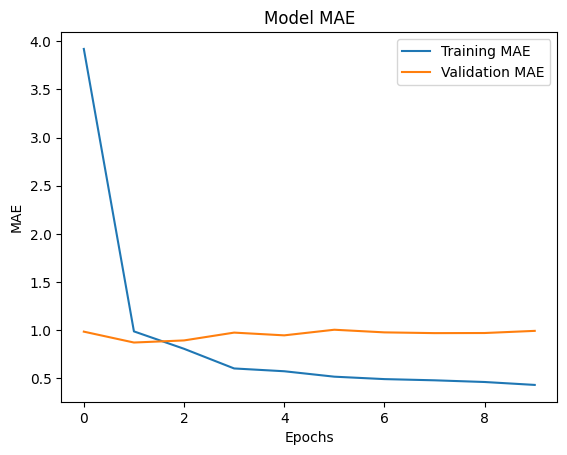

In [65]:
# Plot training & validation MAE
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# 6. Transfer Learning Models

## Model 1 - GloVe Embeddings

In [66]:
# Load GloVe embeddings (e.g., glove.6B.50d.txt - 50-dimensional embeddings)
embedding_index = {}
with open("glove.6B.50d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


## Prepare Tokenized Titles and Embedding Matrix

In [67]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [68]:
# Tokenize and pad the movie titles
tokenizer = Tokenizer(num_words=5000)  # Use top 5000 words for embedding
tokenizer.fit_on_texts(train_titles)
train_title_sequences = tokenizer.texts_to_sequences(train_titles)
test_title_sequences = tokenizer.texts_to_sequences(test_titles)

In [69]:
# Pad sequences to ensure uniform input length
max_length = 15  # Set based on data distribution
train_padded_titles = pad_sequences(train_title_sequences, maxlen=max_length, padding="post")
test_padded_titles = pad_sequences(test_title_sequences, maxlen=max_length, padding="post")

In [70]:
# Create an embedding matrix for GloVe
word_index = tokenizer.word_index
embedding_dim = 50  # GloVe embedding dimension
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

## Define the Transfer Learning Model

In [71]:
# Movie ID input
movie_input_glove = Input(shape=(1,), name="Movie_Input")
movie_embedding_glove = Embedding(
    input_dim=len(unique_movie_ids),
    output_dim=50,
    name="Movie_Embedding_GloVe"
)(movie_input_glove)
movie_flatten_glove = Flatten()(movie_embedding_glove)

In [72]:
# Title input (using GloVe embeddings)
title_input_glove = Input(shape=(max_length,), name="Title_Input_GloVe")
title_embedding_glove = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=False,  # Freeze GloVe weights
    name="Title_Embedding_GloVe"
)(title_input_glove)
title_flatten_glove = Flatten()(title_embedding_glove)

/home/saky/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [73]:
# Concatenate features
concatenated_glove = Concatenate()([movie_flatten_glove, title_flatten_glove])
dense1_glove = Dense(128, activation='relu')(concatenated_glove)
dropout1_glove = Dropout(0.3)(dense1_glove)
dense2_glove = Dense(64, activation='relu')(dropout1_glove)
output_glove = Dense(1, activation='linear', name="Output")(dense2_glove)

In [74]:
# Build the model
glove_model = Model(inputs=[movie_input_glove, title_input_glove], outputs=output_glove)
glove_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
glove_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Movie_Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Title_Input_GloVe   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Movie_Embedding_Gl… │ (None, 1, 50)     │    240,150 │ Movie_Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Title_Embedding_Gl… │ (None, 15, 50)    │    208,000 │ Title_Input_GloV… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50)        │          0 │ Movie_Embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 750)       │          0 │ Title_Embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 800)       │          0 │ flatten_7[0][0],  │
│ (Concatenate)       │                   │            │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    102,528 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         65 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 558,999 (2.13 MB)

 Trainable params: 350,999 (1.34 MB)

 Non-trainable params: 208,000 (812.50 KB)

## Train the Transfer Learning Model

In [75]:
# Train the GloVe-based model
history_glove = glove_model.fit(
    [train_movie_ids, train_padded_titles],
    train_ratings,
    validation_data=([test_movie_ids, test_padded_titles], test_ratings),
    epochs=10,
    batch_size=64
)

Epoch 1/10


/home/saky/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Movie_Input', 'Title_Input_GloVe']. Received: the structure of inputs=('*', '*')
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 18.6610 - mae: 3.7859 - val_loss: 7.3031 - val_mae: 2.0006
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0619 - mae: 1.3232 - val_loss: 4.6079 - val_mae: 1.5267
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9241 - mae: 1.0199 - val_loss: 3.7925 - val_mae: 1.4304
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1485 - mae: 0.7939 - val_loss: 3.6092 - val_mae: 1.3987
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8438 - mae: 0.6746 - val_loss: 3.7431 - val_mae: 1.4421
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6571 - mae: 0.6121 - val_loss: 3.6520 - val_mae: 1.4279
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6024 - mae: 0.5831 - val_loss: 3.6336 - val_mae: 1.4262
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5226 - mae: 0.5550 - val_loss: 3.7381 - val_mae: 1.4888
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5215 - mae: 0.5511 - v

## Model 2: Fine-Tuned Embeddings

In [76]:
# Title input (using fine-tuned GloVe embeddings)
title_input_finetuned = Input(shape=(max_length,), name="Title_Input_FineTuned")
title_embedding_finetuned = Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_length,
    trainable=True,  # Allow embeddings to be fine-tuned
    name="Title_Embedding_FineTuned"
)(title_input_finetuned)
title_flatten_finetuned = Flatten()(title_embedding_finetuned)

In [77]:
# Concatenate features
concatenated_finetuned = Concatenate()([movie_flatten_glove, title_flatten_finetuned])
dense1_finetuned = Dense(128, activation='relu')(concatenated_finetuned)
dropout1_finetuned = Dropout(0.3)(dense1_finetuned)
dense2_finetuned = Dense(64, activation='relu')(dropout1_finetuned)
output_finetuned = Dense(1, activation='linear', name="Output")(dense2_finetuned)

In [78]:
# Build the model
finetuned_model = Model(inputs=[movie_input_glove, title_input_finetuned], outputs=output_finetuned)
finetuned_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
finetuned_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Movie_Input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Title_Input_FineTu… │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Movie_Embedding_Gl… │ (None, 1, 50)     │    240,150 │ Movie_Input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Title_Embedding_Fi… │ (None, 15, 50)    │    208,000 │ Title_Input_Fine… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50)        │          0 │ Movie_Embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 750)       │          0 │ Title_Embedding_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 800)       │          0 │ flatten_7[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │    102,528 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 64)        │      8,256 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 1)         │         65 │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 558,999 (2.13 MB)

 Trainable params: 558,999 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Fine-Tuned Embedding Model

In [79]:
# Train the fine-tuned model
history_finetuned = finetuned_model.fit(
    [train_movie_ids, train_padded_titles],
    train_ratings,
    validation_data=([test_movie_ids, test_padded_titles], test_ratings),
    epochs=10,
    batch_size=64
)

Epoch 1/10


/home/saky/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Movie_Input', 'Title_Input_FineTuned']. Received: the structure of inputs=('*', '*')
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 13.9835 - mae: 3.0379 - val_loss: 1.7937 - val_mae: 1.0251
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0076 - mae: 0.7465 - val_loss: 1.7372 - val_mae: 1.0114
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5884 - mae: 0.5792 - val_loss: 1.9268 - val_mae: 1.0860
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4954 - mae: 0.5406 - val_loss: 2.0636 - val_mae: 1.1402
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4505 - mae: 0.5181 - val_loss: 2.2422 - val_mae: 1.2006
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4372 - mae: 0.5096 - val_loss: 2.0238 - val_mae: 1.1224
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3721 - mae: 0.4703 - val_loss: 2.0690 - val_mae: 1.1443
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3364 - mae: 0.4498 - val_loss: 2.0381 - val_mae: 1.1317
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3021 - mae: 0.4308 - v

# 7. Evaluate and Compare All Three Models

## Predictions and Evaluations

In [80]:
# Predict using all models
deep_pred = deep_learning_model.predict([test_movie_ids, test_titles_encoded]).flatten()
glove_pred = glove_model.predict([test_movie_ids, test_padded_titles]).flatten()
finetuned_pred = finetuned_model.predict([test_movie_ids, test_padded_titles]).flatten()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [83]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate the performance of a model.

    Parameters:
        y_true (array-like): True ratings/labels.
        y_pred (array-like): Predicted ratings/labels.
        model_name (str): Name of the model being evaluated.

    Returns:
        dict: A dictionary containing evaluation metrics.
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)

    print(f"Evaluation Results for {model_name}:")
    print(f"- Mean Absolute Error (MAE): {mae:.4f}")
    print(f"- Root Mean Square Error (RMSE): {rmse:.4f}")
    print(f"- R-squared (R2): {r2:.4f}")

    return {
        "model": model_name,
        "mae": mae,
        "rmse": rmse,
        "r2": r2
    }


In [84]:
# Evaluate each model
deep_results = evaluate_model(test_ratings, deep_pred, "Deep Learning Model")
glove_results = evaluate_model(test_ratings, glove_pred, "GloVe Transfer Learning Model")
finetuned_results = evaluate_model(test_ratings, finetuned_pred, "Fine-Tuned Transfer Learning Model")

Evaluation Results for Deep Learning Model:
- Mean Absolute Error (MAE): 0.9935
- Root Mean Square Error (RMSE): 1.3082
- R-squared (R2): -0.3203
Evaluation Results for GloVe Transfer Learning Model:
- Mean Absolute Error (MAE): 1.3894
- Root Mean Square Error (RMSE): 1.8442
- R-squared (R2): -1.6241
Evaluation Results for Fine-Tuned Transfer Learning Model:
- Mean Absolute Error (MAE): 1.1930
- Root Mean Square Error (RMSE): 1.4838
- R-squared (R2): -0.6986


# 8. Visualize Performance Comparison

In [88]:
# Store results in a list
results = [deep_results, glove_results, finetuned_results]

In [89]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results table
print("Model Evaluation Results:")
print(results_df)

Model Evaluation Results:
                                model       mae      rmse        r2
0                 Deep Learning Model  0.993535  1.308178 -0.320323
1       GloVe Transfer Learning Model  1.389393  1.844224 -1.624058
2  Fine-Tuned Transfer Learning Model  1.192994  1.483788 -0.698596


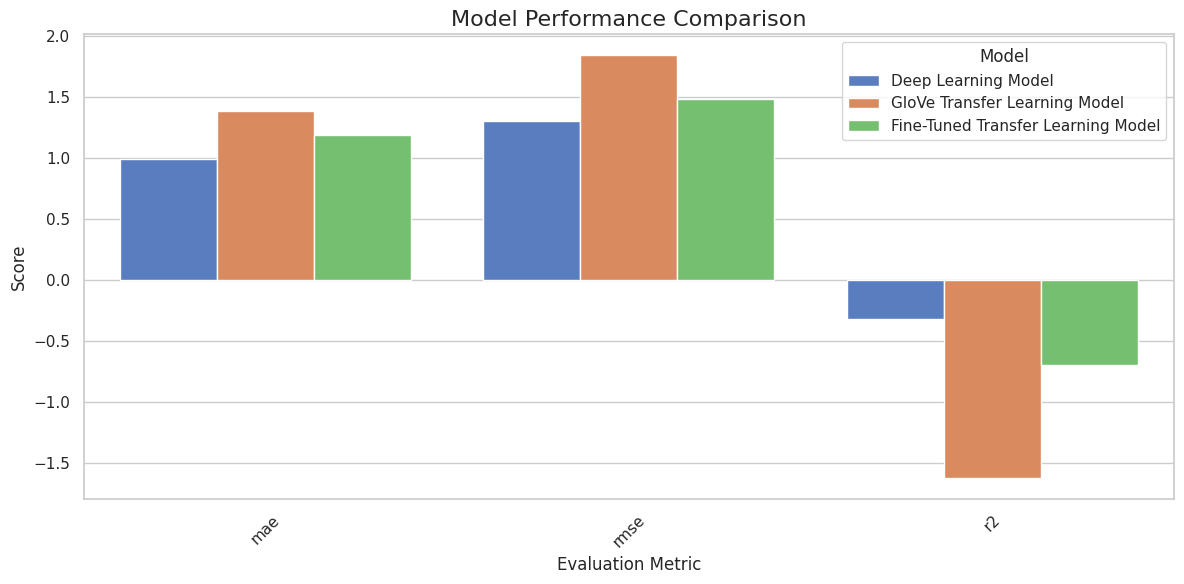

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set(style="whitegrid")

# Melt the DataFrame for visualization
results_melted = results_df.melt(id_vars="model", var_name="Metric", value_name="Value")

# Plot metrics for each model
plt.figure(figsize=(12, 6))
sns.barplot(x="Metric", y="Value", hue="model", data=results_melted, palette="muted")
plt.title("Model Performance Comparison", fontsize=16)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Evaluation Metric", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="Model", loc="upper right")
plt.tight_layout()

# Show the plot
plt.show()

In [92]:
# Save the DataFrame to a CSV file
results_df.to_csv("model_evaluation_results.csv", index=False)
print("Results saved to model_evaluation_results.csv")

Results saved to model_evaluation_results.csv


In [93]:
# Save the plot as an image
plt.savefig("model_evaluation_comparison.png", dpi=300)
print("Plot saved as model_evaluation_comparison.png")

Plot saved as model_evaluation_comparison.png


<Figure size 640x480 with 0 Axes>

# Thank You